In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import RandomOverSampler ,SMOTE
from collections import Counter
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fastapi import FastAPI
from pydantic import BaseModel
import mlflow
from datetime import datetime
from pydantic import BaseModel
import joblib
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import mlflow
import time
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import mlflow
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from email.message import EmailMessage
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

ModuleNotFoundError: No module named 'evidently.report'

In [ ]:
health_care = pd.read_csv("cleaned_data.csv")
health_care_df = pd.DataFrame(health_care)
health_care_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category,bmi_category,glucose_category
0,0,0.817073,0,1,1,0,0,0.801265,0.745455,0,1,2,3,4
1,1,0.743902,0,0,1,1,1,0.679023,0.487879,1,1,2,2,4
2,0,0.975610,0,1,1,0,1,0.234512,0.621212,1,1,2,3,3
3,1,0.597561,0,0,1,0,0,0.536008,0.678788,2,1,1,3,2
4,1,0.963415,1,0,1,1,1,0.549349,0.363636,1,1,2,1,2


In [ ]:
print("Data Shape:", health_care_df.shape)
print("\nMissing Values:", health_care_df.isnull().sum().max())
print("\nClass Distribution:\n", health_care_df['stroke'].value_counts(normalize=True))

Data Shape: (5110, 14)

Missing Values: 0

Class Distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


In [ ]:
X = health_care_df.drop(['stroke'], axis=1)
y = health_care_df['stroke']

In [ ]:
smote = SMOTE(sampling_strategy=0.7,random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_smote))

After SMOTE: Counter({0: 4861, 1: 3402})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Class distribution in training:", Counter(y_train))

Class distribution in training: Counter({0: 3889, 1: 2721})


# <span style="color:green">Loading our model</span>

In [ ]:
xg_model = joblib.load("xgboost_model.pkl")

In [ ]:
xg_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:

y_pred = xg_model.predict(X_test_scaled)
y_proba = xg_model.predict_proba(X_test_scaled)[:,1]
acc = accuracy_score(y_test, y_pred)

In [ ]:
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For Logistic Regression :", roc_auc_score(y_test, y_proba))


Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       972
           1       0.86      0.96      0.91       681

    accuracy                           0.92      1653
   macro avg       0.91      0.92      0.92      1653
weighted avg       0.92      0.92      0.92      1653


AUC-ROC For Logistic Regression : 0.978547645377471


# <span style="color:green"> MLOps with MLflow
</span>

In [ ]:
mlflow.set_experiment("Stroke-Prediction-XGBoost")    

<Experiment: artifact_location='file:///c:/Ebrahim/Depi%20final%20project/mlruns/170140672330673608', creation_time=1746789991817, experiment_id='170140672330673608', last_update_time=1746789991817, lifecycle_stage='active', name='Stroke-Prediction-XGBoost', tags={}>

In [ ]:
if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run():
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

C:\Users\ebrah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [17:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

In [ ]:
mlflow.log_param("model_type", "XGBoost")

'XGBoost'

# <span style="color:green"> Logging the metrics of our model
</span>

In [ ]:

mlflow.log_metric("accuracy", acc)
mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
mlflow.log_metric("precision", precision_score(y_test, y_pred))
mlflow.log_metric("recall", recall_score(y_test, y_pred))
mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))

In [ ]:
mlflow.xgboost.log_model(model, artifact_path="xgb_model")
print(f"Logged XGBoost model with accuracy: {acc:.4f}")

C:\Users\ebrah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/09 17:16:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost model with accuracy: 0.9341


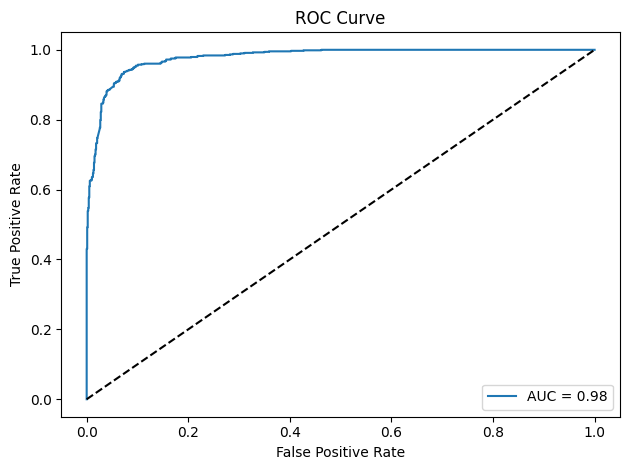

In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")

# <span style="color:green"> Preformance reporting and model monitoring
</span>

In [13]:
report_text = classification_report(y_test, y_pred)
from evidently.report import Report

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(report_text)


NameError: name 'y_test' is not defined

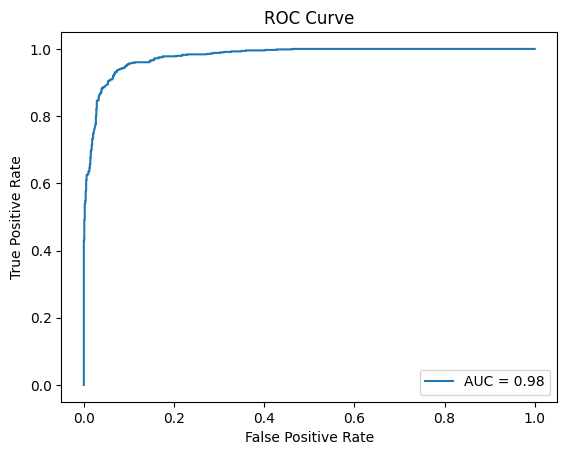

In [ ]:
if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run(run_name="Evaluation on new data"):
    mlflow.log_metric("eval_accuracy", acc)
    mlflow.log_metric("eval_auc", roc_auc)

    # ROC Curve plot
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig("roc_eval.png")
    mlflow.log_artifact("roc_eval.png")

    # Save classification report
    with open("classification_eval.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_eval.txt")

In [ ]:
reference_data = pd.read_csv("cleaned_data.csv")  

drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=reference_data, current_data=X_test)
drift_report.save_html("drift_report.html")
mlflow.log_artifact("drift_report.html")

NameError: name 'Report' is not defined